<a href="https://colab.research.google.com/github/foundpriv/foundpriv.github.io/blob/main/docs/code/Found_Priv_HW3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Foundations of Privacy HW3 Programming Component
In this assignment, you will play with the DPSGD implementation in tensorflow privacy. 

The coding exercise is at the end of the document. You should run all your code and download the ipynb file. For the submission, you should create a zip file that contains both the written component (pdf) and the programming component (ipynb).

# Loading basic libraries
We will begin by importing/installing these libraries. 
* [numpy](https://docs.scipy.org/doc/)
* [tensorflow](https://www.tensorflow.org/overview)
* [tensorflow privacy](https://github.com/tensorflow/privacy)

You are encouraged to read the documentation of these libraries, especially these tensorflow privacy [tutorials](https://github.com/tensorflow/privacy/tree/master/tutorials).

In [1]:
import numpy as np

import tensorflow as tf
!pip -q install tensorflow_privacy

from tensorflow_privacy.privacy.analysis.rdp_accountant import compute_rdp
from tensorflow_privacy.privacy.analysis.rdp_accountant import get_privacy_spent
from tensorflow_privacy.privacy.keras_models.dp_keras_model import DPSequential

# Other basic functions 
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from absl import logging

     |████████████████████████████████| 251 kB 5.3 MB/s 
     |████████████████████████████████| 4.0 MB 36.3 MB/s 


# Loading Data Set
The MNIST data set is perhaps the most commonly used data set for testing ML algorithms.

In [2]:
def load_mnist():
  """Loads MNIST and preprocesses to combine training and validation data."""
  train, test = tf.keras.datasets.mnist.load_data()
  train_data, train_labels = train
  test_data, test_labels = test

  train_data = np.array(train_data, dtype=np.float32) / 255
  test_data = np.array(test_data, dtype=np.float32) / 255

  train_data = train_data.reshape((train_data.shape[0], 28, 28, 1))
  test_data = test_data.reshape((test_data.shape[0], 28, 28, 1))

  train_labels = np.array(train_labels, dtype=np.int32)
  test_labels = np.array(test_labels, dtype=np.int32)

  train_labels = tf.keras.utils.to_categorical(train_labels, num_classes=10)
  test_labels = tf.keras.utils.to_categorical(test_labels, num_classes=10)

  assert train_data.min() == 0.
  assert train_data.max() == 1.
  assert test_data.min() == 0.
  assert test_data.max() == 1.

  return train_data, train_labels, test_data, test_labels

# Load training and test data.
train_data, train_labels, test_data, test_labels = load_mnist()

11501568/11490434 [==============================] - 0s 0us/step


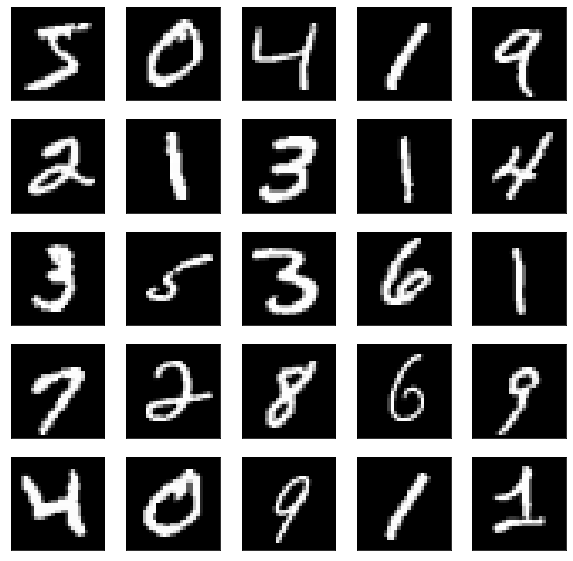

In [3]:
# A snapshot of the data
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_data[i].squeeze(), cmap='gray')
plt.show()

# Privacy Accountant
The tensorflow library comes with a nice tool (sometimes called the *privacy accountant*) that computes the value of epsilon when it is given the parameters of DPSGD and the specifed value of delta.

You can essentially think of this as an optimized tool that applies the *advanced composition theorem* for you automatically.

* steps: T
* noise_multiplier: sigma / clip_norm. In other words, the standard deviation of the Gaussian noise sigma = clip_norm * noise_multiplier.
* batch_size = |B_t|

In [4]:
def compute_epsilon(steps, noise_multiplier, batch_size):
  """Computes epsilon value for given hyperparameters."""
  if noise_multiplier == 0.0:
    return float('inf')
  orders = [1 + x / 10. for x in range(1, 100)] + list(range(12, 64))
  sampling_probability = batch_size / 60000
  rdp = compute_rdp(
      q=sampling_probability,
      noise_multiplier=noise_multiplier,
      steps=steps,
      orders=orders)
  # Delta is set to 1e-6, which is much less than 60000, the number of training points.
  return get_privacy_spent(orders, rdp, target_delta=1e-6)[0]

# Creating a machine learning model
The following code creates a neural network architecture for image classification. You do not need to understand this part.

In [5]:
# Define a Convolutional Neural Network Architecture (sequential Keras model)
layers = [
      tf.keras.layers.Conv2D(
          16,
          8,
          strides=2,
          padding='same',
          activation='relu',
          input_shape=(28, 28, 1)),
      tf.keras.layers.MaxPool2D(2, 1),
      tf.keras.layers.Conv2D(
          32, 4, strides=2, padding='valid', activation='relu'),
      tf.keras.layers.MaxPool2D(2, 1),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(32, activation='relu'),
      tf.keras.layers.Dense(10)
  ]

# DPSGD Code
The following code runs the implementation of DPSGD in tensorflow.

In [6]:
def run_dpsgd(params):
  dpsgd = params["dpsgd"]
  learning_rate = params["learning_rate"]
  noise_multiplier = params["noise_multiplier"]
  l2_norm_clip = params["l2_norm_clip"]
  batch_size = params["batch_size"]
  epochs = params["epochs"]
  microbatches = params["microbatches"]

  # Compute the privacy budget that will be expended. You can compute it without running the algorithm
  if dpsgd:
    eps = compute_epsilon(epochs * 60000 // batch_size, noise_multiplier, batch_size)
    print('For delta=1e-6, the current epsilon is: %.2f' % eps)
  else:
    print('Trained with vanilla non-private SGD optimizer')

  logging.set_verbosity(logging.INFO)
  if dpsgd and batch_size % microbatches != 0:
    raise ValueError('Number of microbatches should divide evenly batch_size')

  # Define DPSGD optimizer
  if dpsgd:
    model = DPSequential(
        l2_norm_clip=l2_norm_clip,
        noise_multiplier=noise_multiplier,
        layers=layers)
  else:
    model = tf.keras.Sequential(layers=layers)

  optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
  loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

  # Compile model with Keras
  model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

  # Train model with Keras
  history = model.fit(
      train_data,
      train_labels,
      epochs=epochs,
      validation_data=(test_data, test_labels),
      batch_size=batch_size)

  return history

# Trying out different DPSGD parameters.

In [7]:
#Defining parameters for running DP-SGD
example_params = {
  "dpsgd" : True, # you should always set this to be True in the HW
  "learning_rate" : 0.15, # eta
  "noise_multiplier" : 1,
  "l2_norm_clip" : 1.0,
  "batch_size" : 250,
  "epochs" : 3,
  "microbatches" : 50
}

history = run_dpsgd(example_params)

For delta=1e-6, the current epsilon is: 1.27
Epoch 1/3
240/240 [==============================] - 53s 186ms/step - loss: 1.6537 - accuracy: 0.4932 - val_loss: 0.8754 - val_accuracy: 0.7237
Epoch 2/3
240/240 [==============================] - 45s 187ms/step - loss: 0.7086 - accuracy: 0.7756 - val_loss: 0.5443 - val_accuracy: 0.8263
Epoch 3/3
240/240 [==============================] - 45s 187ms/step - loss: 0.5984 - accuracy: 0.8542 - val_loss: 0.4095 - val_accuracy: 0.8841


In [8]:
# You could replay the history 
history.history

{'accuracy': [0.49318334460258484, 0.7755666375160217, 0.8541833162307739],
 'loss': [1.653725504875183, 0.7086288928985596, 0.5983629822731018],
 'val_accuracy': [0.7236999869346619, 0.8263000249862671, 0.8841000199317932],
 'val_loss': [0.8753639459609985, 0.5443020462989807, 0.409490704536438]}

## Problem: searching DP-SGD parameters
Now it's your turn. Find three sets of parameters such that the resulting epsilon is less than 1 and delta is 1e-6.

Identify which one has the highest validation accuracy.

In [ ]:
# FILL IN
params_1 = {}

history = run_dpsgd(params_1)

In [ ]:
# FILL IN
params_2 = {}

history = run_dpsgd(params_2)

In [ ]:
# FILL IN
params_3 = {}

history = run_dpsgd(params_3)

### Question
What is the highest validation and training accuracy you get? What would be your strategy to choose the parameters to optimize accuracy subject to a fixed level of privacy.

(*Double click to type in your answer*)